# Example Pipeline for Simulated Data

This notebook is a proof-of-concept for generating causal samples from external samples

In [11]:
import sys
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 50,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}

seed = 0
N = 500
sampling_size = 1000
causal_params = [0, 1]
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

In [15]:
X_samples

Array([0, 0, 1, 1], dtype=int64)

In [17]:
X_samples = jnp.array([0,0,1,1])
u_yx = jnp.array([0.1]*4)
sample_outcome(
    key=jr.PRNGKey(0),
    n_samples=4,
    causal_model='causal_cdf',
    causal_condition=X_samples[:, None],
    u_yx=u_yx.flatten(),
    **{'ate': 8, 'const': 0, 'scale': 1}
)

Array([-1.28155157, -1.28155157, -1.28155157, -1.28155157], dtype=float64)

In [49]:
sim_data_df.head()

,Y,X,Z_1,Z_2,Z_3,Z_4
0,2.787106,0.0,-0.082236,-0.203157,0.0,1.0
1,2.800403,0.0,-1.479328,-1.429590,1.0,0.0
2,2.658754,1.0,0.015966,-2.114188,0.0,1.0
3,3.460166,0.0,-0.595838,-1.224513,0.0,1.0
4,3.460441,1.0,-0.696365,0.821778,1.0,0.0


In [10]:
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=sampling_size,
    copula_param=0.,
    outcome_causal_model='location_translation',
    outcome_causal_args={'ate': 5, 'const': 3, 'scale': 0.5}
)
valMethods.metalearner('Y', 'X', sim_data_df, est='T', method='GBR')

[[1]
 [1]
 [1]
 [0]
 [0]]


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.


ValueError: location_translation causal_model requires a 'location_translation' pretrained frugal_flow

In [5]:
sim_data_df

,Y,X,Z_1,Z_2,Z_3,Z_4
0,0.142275,1.0,1.046143,0.083095,0.0,0.0
1,-0.098038,1.0,0.341016,-1.025302,0.0,1.0
2,-0.150735,1.0,-0.057822,1.902309,1.0,1.0
3,0.416988,0.0,-0.707027,-1.784100,1.0,1.0
4,-2.251077,0.0,-0.672104,0.402837,0.0,0.0
...,...,...,...,...,...,...
195,0.364163,0.0,-0.688518,-0.350289,1.0,1.0
196,0.291068,1.0,0.498968,1.243259,1.0,1.0
197,0.960422,0.0,1.441816,-1.484053,1.0,1.0
198,0.766779,1.0,0.064496,0.433469,1.0,1.0


In [2]:
N = 1000
B = 10 # Number of Bootstraps
sampling_size = 200
causal_params = [0, 1]
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)
hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 50,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}

Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(N=N, seed=seed, causal_params=causal_params).values()
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='gaussian',
    causal_model_args={'ate': 0, 'const': 0, 'scale': 1},
    prop_flow_hyperparam_dict=hyperparam_dict
)
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=sampling_size,
    copula_param=0.,
    outcome_causal_model='causal_cdf',
    outcome_causal_args={'ate': 5, 'const': 3, 'scale': 0.5}
)
valMethods.metalearner('Y', 'X', sim_data_df, est='T', method='GBR')

 11%|██████████▎                                                                                      | 106/1000 [00:05<00:44, 19.97it/s, train=-0.9356698737563767, val=0.16441727803762693 (Max patience reached)]


[[1]
 [1]
 [1]
 [0]
 [0]]


(0.06880835743651337, (-0.7311043279218875, 0.868721042794914))

In [ ]:
benchmark_flow.

In [47]:
display(model_fits)

{'bootstrap_results':           method       ate                                         lower_conf  \
 0  Diff. of Mean  0.359945                                               None   
 1    Causal BART  0.043625                                               None   
 2  Causal Forest  0.068289  0     -0.0
 1     -0.0
 2     -0.0
 3     -0.0
 4 ...   
 
                                           upper_conf  
 0                                               None  
 1                                               None  
 2  0      0.0
 1      0.0
 2      0.0
 3      0.0
 4 ...  ,
 'nonbootstrap_results':                                method                    ate  \
 0         Gradient Boosting Trees DML               2.697496   
 1                          Linear DML              -0.132793   
 2              Doubly Robust (Linear)              -0.829594   
 3                    Linear T Learner              -0.067332   
 4                    Linear S Learner              -0.060311   
 5

In [2]:
N = 1000
B = 10 # Number of Bootstraps
sampling_size = 200
causal_params = [0, 1]
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)
hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 50,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}
results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(N=N, seed=seed, causal_params=causal_params).values()
    benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)
    benchmark_flow.train_benchmark_model(
        training_seed=jr.PRNGKey(seed),
        marginal_hyperparam_dict=hyperparam_dict,
        frugal_hyperparam_dict=hyperparam_dict,
        causal_model='gaussian',
        causal_model_args={'ate': 0, 'const': 0, 'scale': 1},
        prop_flow_hyperparam_dict=hyperparam_dict
    )
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.8,
        outcome_causal_model='causal_cdf',
        outcome_causal_args={'ate': 5, 'const': 3, 'scale': 0.5}
    )
    model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    results_list.append(ate_reslts)
model_fit_results = pd.concat(results_list)

Run 1 / 10


 11%|██████████▎                                                                                      | 106/1000 [00:05<00:43, 20.62it/s, train=-0.9356698737563767, val=0.16441727803762693 (Max patience reached)]
2024-05-19 23:07:39,881 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:07:55,135 Fitting model: Linear DML
2024-05-19 23:08:56,053 Fitting model: Doubly Robust (Linear)
2024-05-19 23:09:57,470 Fitting model: Linear T Learner
2024-05-19 23:09:57,734 Fitting model: Linear S Learner
2024-05-19 23:09:57,950 Fitting model: Linear X Learner
2024-05-19 23:10:02,790 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:10:07,551 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:10:09,978 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:10:22,848 Fitting model: Propensity Score Matching
2024-05-19 23:10:23,519 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 2 / 10


 12%|███████████▋                                                                                     | 120/1000 [00:05<00:39, 22.46it/s, train=-1.1134617669316464, val=0.17128248724268763 (Max patience reached)]
2024-05-19 23:11:30,595 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:11:46,125 Fitting model: Linear DML
2024-05-19 23:12:45,074 Fitting model: Doubly Robust (Linear)
2024-05-19 23:13:44,773 Fitting model: Linear T Learner
2024-05-19 23:13:44,999 Fitting model: Linear S Learner
2024-05-19 23:13:45,188 Fitting model: Linear X Learner
2024-05-19 23:13:49,706 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:13:53,954 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:13:56,303 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:14:09,002 Fitting model: Propensity Score Matching
2024-05-19 23:14:09,106 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 3 / 10


 11%|██████████▋                                                                                       | 109/1000 [00:04<00:40, 21.90it/s, train=-1.076613067652853, val=0.34423602673439296 (Max patience reached)]
2024-05-19 23:14:39,375 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:14:54,384 Fitting model: Linear DML
2024-05-19 23:15:53,824 Fitting model: Doubly Robust (Linear)
2024-05-19 23:16:50,721 Fitting model: Linear T Learner
2024-05-19 23:16:50,972 Fitting model: Linear S Learner
2024-05-19 23:16:51,179 Fitting model: Linear X Learner
2024-05-19 23:16:55,895 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:17:00,253 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:17:02,685 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:17:15,836 Fitting model: Propensity Score Matching
2024-05-19 23:17:15,944 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 4 / 10


 11%|██████████▊                                                                                      | 112/1000 [00:05<00:41, 21.35it/s, train=-1.0206933853610705, val=0.43251593904222085 (Max patience reached)]
2024-05-19 23:17:42,159 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:17:57,354 Fitting model: Linear DML
2024-05-19 23:18:57,055 Fitting model: Doubly Robust (Linear)
2024-05-19 23:19:57,184 Fitting model: Linear T Learner
2024-05-19 23:19:57,430 Fitting model: Linear S Learner
2024-05-19 23:19:57,617 Fitting model: Linear X Learner
2024-05-19 23:20:02,559 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:20:06,922 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:20:09,315 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:20:21,866 Fitting model: Propensity Score Matching
2024-05-19 23:20:21,999 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 5 / 10


 12%|███████████▎                                                                                      | 116/1000 [00:05<00:40, 21.58it/s, train=-1.1141401994678892, val=0.4376610945583569 (Max patience reached)]
2024-05-19 23:20:51,907 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:21:07,656 Fitting model: Linear DML
2024-05-19 23:22:04,964 Fitting model: Doubly Robust (Linear)
2024-05-19 23:23:01,727 Fitting model: Linear T Learner
2024-05-19 23:23:01,967 Fitting model: Linear S Learner
2024-05-19 23:23:02,156 Fitting model: Linear X Learner
2024-05-19 23:23:06,895 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:23:11,243 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:23:13,691 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:23:26,181 Fitting model: Propensity Score Matching
2024-05-19 23:23:26,288 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 6 / 10


 11%|███████████▎                                                                                       | 114/1000 [00:05<00:41, 21.40it/s, train=-1.100386679661423, val=0.4022396892640279 (Max patience reached)]
2024-05-19 23:23:53,372 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:24:08,815 Fitting model: Linear DML
2024-05-19 23:25:05,020 Fitting model: Doubly Robust (Linear)
2024-05-19 23:26:02,752 Fitting model: Linear T Learner
2024-05-19 23:26:03,005 Fitting model: Linear S Learner
2024-05-19 23:26:03,206 Fitting model: Linear X Learner
2024-05-19 23:26:07,911 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:26:12,217 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:26:14,615 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:26:27,138 Fitting model: Propensity Score Matching
2024-05-19 23:26:27,253 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 7 / 10


 11%|██████████▍                                                                                      | 108/1000 [00:05<00:42, 20.88it/s, train=-1.0881308292899359, val=0.21370564283177057 (Max patience reached)]
2024-05-19 23:26:54,481 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:27:09,416 Fitting model: Linear DML
2024-05-19 23:28:09,021 Fitting model: Doubly Robust (Linear)
2024-05-19 23:29:07,528 Fitting model: Linear T Learner
2024-05-19 23:29:07,742 Fitting model: Linear S Learner
2024-05-19 23:29:07,925 Fitting model: Linear X Learner
2024-05-19 23:29:12,523 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:29:16,762 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:29:19,132 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:29:31,584 Fitting model: Propensity Score Matching
2024-05-19 23:29:31,686 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 8 / 10


 13%|████████████▎                                                                                    | 127/1000 [00:05<00:36, 23.98it/s, train=-1.1204668537637141, val=0.10332476243442679 (Max patience reached)]
2024-05-19 23:30:01,812 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:30:17,264 Fitting model: Linear DML
2024-05-19 23:31:15,851 Fitting model: Doubly Robust (Linear)
2024-05-19 23:32:15,101 Fitting model: Linear T Learner
2024-05-19 23:32:15,328 Fitting model: Linear S Learner
2024-05-19 23:32:15,516 Fitting model: Linear X Learner
2024-05-19 23:32:19,984 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:32:24,186 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:32:26,566 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:32:39,687 Fitting model: Propensity Score Matching
2024-05-19 23:32:39,785 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 9 / 10


 12%|███████████▌                                                                                      | 118/1000 [00:05<00:37, 23.30it/s, train=-1.0642372937239721, val=0.3716935215498275 (Max patience reached)]
2024-05-19 23:33:04,627 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:33:19,909 Fitting model: Linear DML
2024-05-19 23:34:17,851 Fitting model: Doubly Robust (Linear)
2024-05-19 23:35:13,662 Fitting model: Linear T Learner
2024-05-19 23:35:13,894 Fitting model: Linear S Learner
2024-05-19 23:35:14,073 Fitting model: Linear X Learner
2024-05-19 23:35:18,744 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:35:23,961 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:35:26,338 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:35:38,725 Fitting model: Propensity Score Matching
2024-05-19 23:35:38,835 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

Run 10 / 10


 11%|██████████▉                                                                                         | 109/1000 [00:05<00:46, 19.14it/s, train=-1.013057858508993, val=0.265922233450651 (Max patience reached)]
2024-05-19 23:36:30,263 Fitting model: Gradient Boosting Trees DML
2024-05-19 23:36:45,333 Fitting model: Linear DML
2024-05-19 23:37:45,471 Fitting model: Doubly Robust (Linear)
2024-05-19 23:38:45,192 Fitting model: Linear T Learner
2024-05-19 23:38:45,438 Fitting model: Linear S Learner
2024-05-19 23:38:45,627 Fitting model: Linear X Learner
2024-05-19 23:38:50,209 Fitting model: Gradient Boosting Trees T Learner
2024-05-19 23:38:55,410 Fitting model: Gradient Boosting Trees S Learner
2024-05-19 23:38:57,883 Fitting model: Gradient Boosting Trees X Learner
2024-05-19 23:39:10,584 Fitting model: Propensity Score Matching
2024-05-19 23:39:10,731 Fitting model: TMLE
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is depreca

In [10]:
model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])

1     False
2      True
3     False
4     False
5     False
      ...  
9     False
10    False
0     False
1     False
2     False
Name: method, Length: 130, dtype: bool

In [13]:
model_fit_results = pd.concat(results_list)
def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value
model_fit_results = model_fit_results.loc[
    ~model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
model_fit_results['ate'] = model_fit_results['ate'].apply(clean_ate)
summary_df = model_fit_results.groupby('method')['ate'].agg(['mean', 'std']).reset_index()

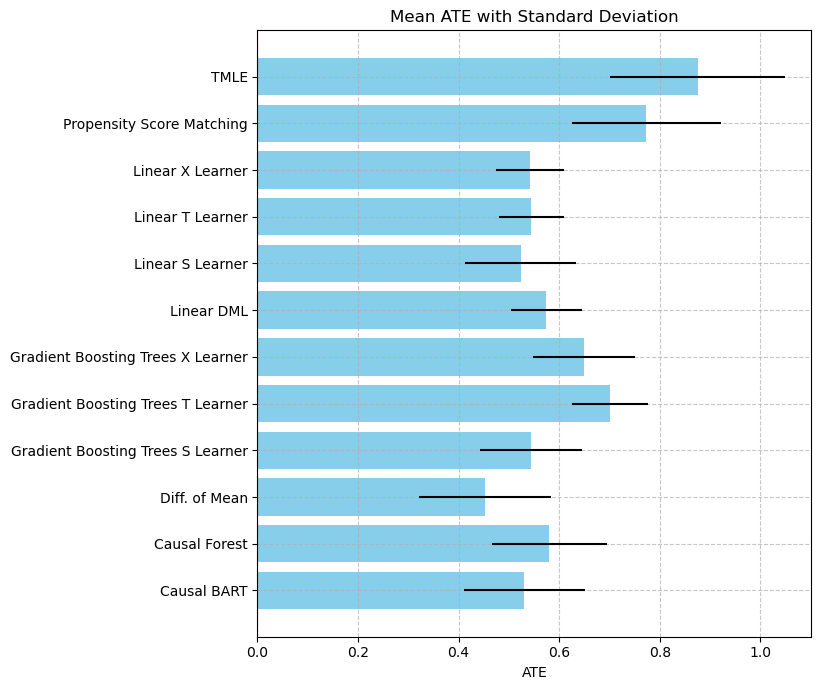

In [14]:
# Plot the mean and standard deviation of ATE for each method
plt.figure(figsize=(14, 7))

# Plot bias as mean ATE
plt.subplot(1, 2, 1)
plt.barh(summary_df['method'], summary_df['mean'], xerr=summary_df['std'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('ATE')
plt.title('Mean ATE with Standard Deviation')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

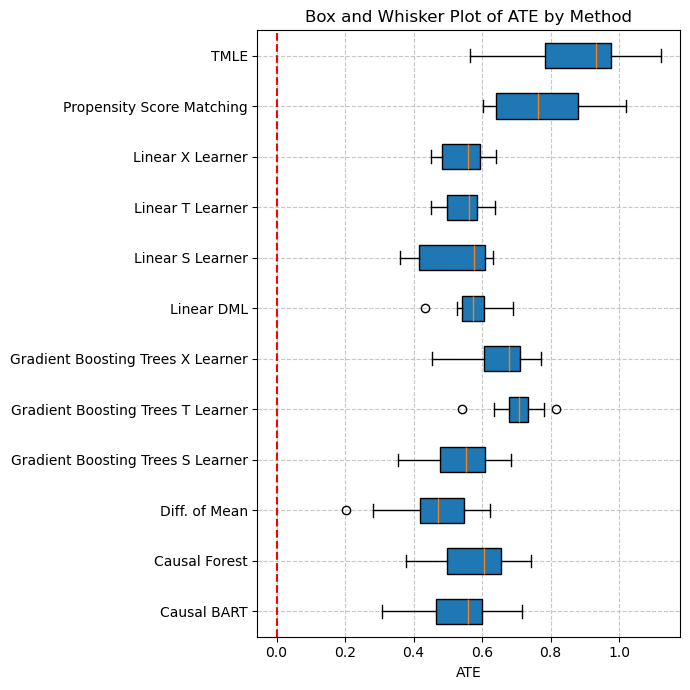

In [15]:
plt.figure(figsize=(7, 7))
grouped_df = model_fit_results.groupby('method')['ate'].apply(list).reset_index()

# Create the boxplot
plt.boxplot(grouped_df['ate'], vert=False, patch_artist=True, labels=grouped_df['method'])

# Customize the plot
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('ATE')
plt.title('Box and Whisker Plot of ATE by Method')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

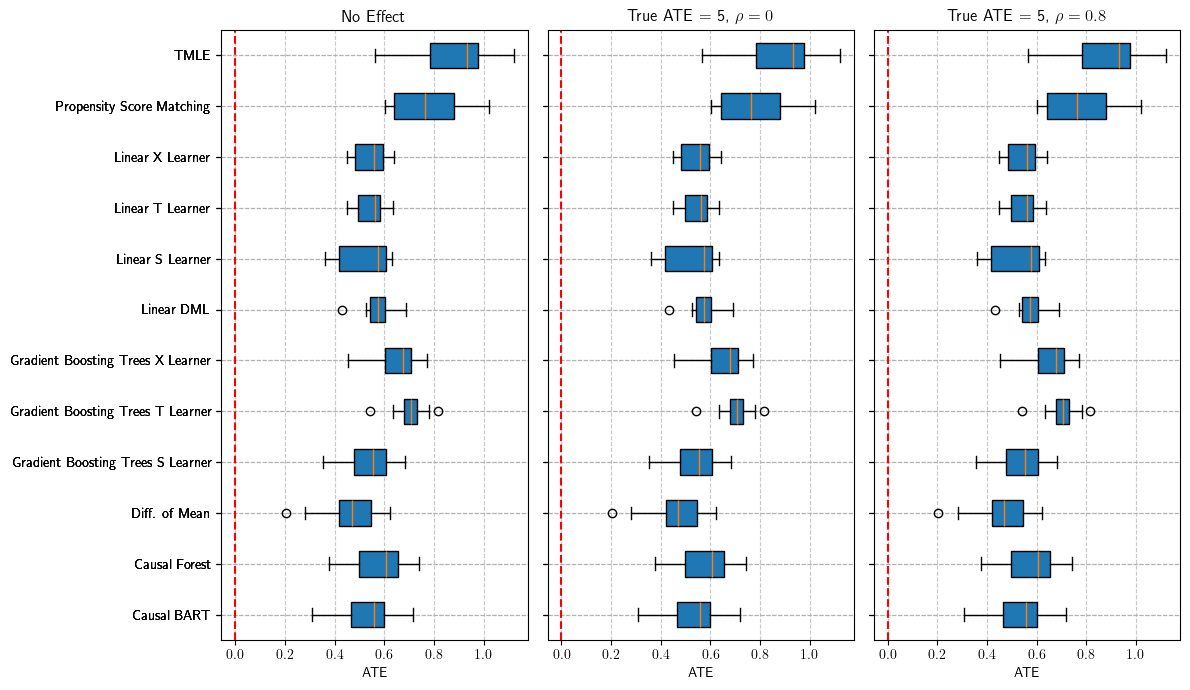

In [32]:
plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df = pd.concat(results_list)
def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value
model_fit_results = model_fit_results.loc[
    ~model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
model_fit_results['ate'] = model_fit_results['ate'].apply(clean_ate)
df1 = model_fit_results.copy()
df2 = model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 7), sharey=True)

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('ATE')
axes[0].set_title('No Effect')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('ATE')
axes[1].set_title(r'True ATE = 5, $\rho=0$')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[2].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[2].axvline(x=0, color='red', linestyle='--')
axes[2].set_xlabel('ATE')
axes[2].set_title(r'True ATE = 5,  $\rho=0.8$')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

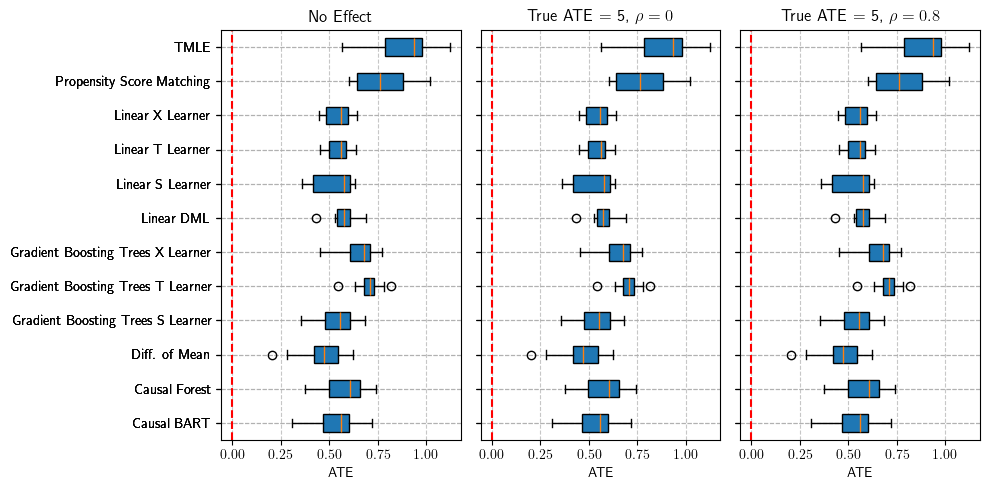

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df = pd.concat(results_list)

model_fit_results = model_fit_results.loc[
    ~model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
model_fit_results['ate'] = model_fit_results['ate'].apply(clean_ate)
df1 = model_fit_results.copy()
df2 = model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('ATE')
axes[0].set_title('No Effect')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('ATE')
axes[1].set_title(r'True ATE = 5, $\rho=0$')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[2].axvline(x=0, color='red', linestyle='--')
axes[2].set_xlabel('ATE')
axes[2].set_title(r'True ATE = 5,  $\rho=0.8$')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('simulated_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()


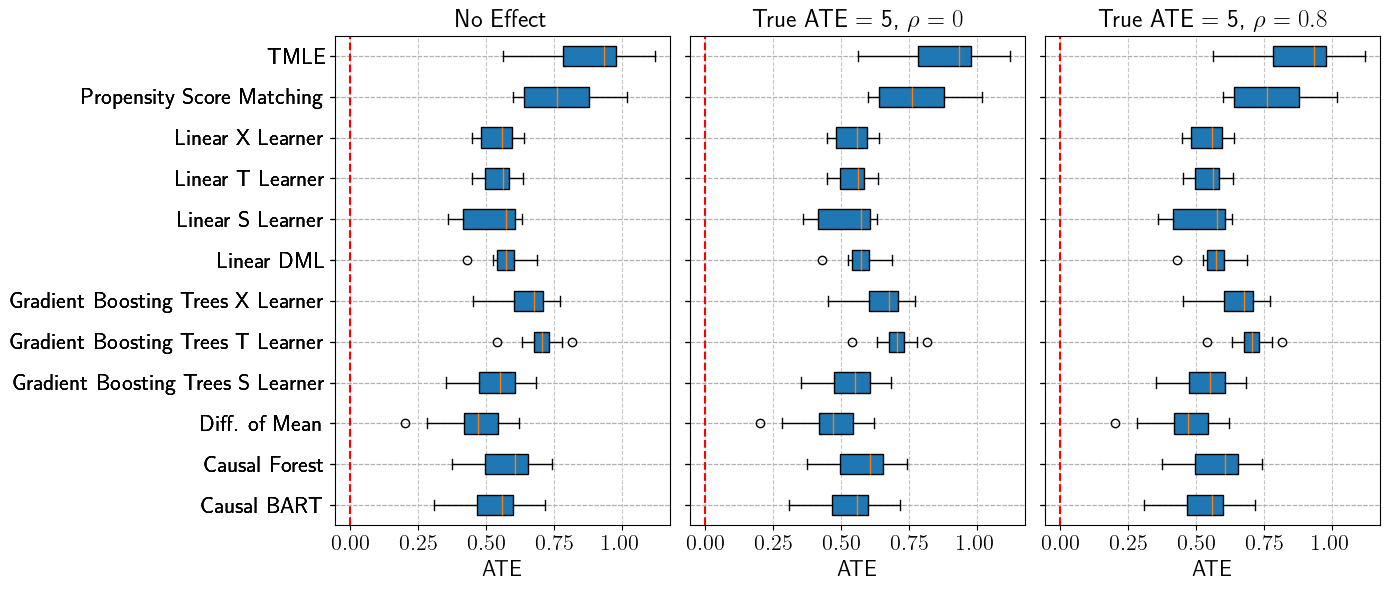

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df = pd.concat(results_list)

model_fit_results = model_fit_results.loc[
    ~model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
model_fit_results['ate'] = model_fit_results['ate'].apply(clean_ate)
df1 = model_fit_results.copy()
df2 = model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)

# Define a common font size
font_size = 16

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('ATE', fontsize=font_size)
axes[0].set_title('No Effect', fontsize=font_size+2)
axes[0].tick_params(axis='both', which='major', labelsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('ATE', fontsize=font_size)
axes[1].set_title(r'True ATE = 5, $\rho=0$', fontsize=font_size+2)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[2].axvline(x=0, color='red', linestyle='--')
axes[2].set_xlabel('ATE', fontsize=font_size)
axes[2].set_title(r'True ATE = 5,  $\rho=0.8$', fontsize=font_size+2)
axes[2].tick_params(axis='both', which='major', labelsize=font_size)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('simulated_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()